In [3]:
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib

sys.path.append("..")

from data.sources import destatis_sources, bkg_source, processed_dir, raw_dir
from elternsein.utils import rs_state, state_rs, num, cuyo
from elternsein.colors import color_rgba

# Elterngeld: Basisdaten von destatis

Hier führen wir einige Grunddaten ein, die bei destatis verfügbar sind.
"Verfügbar" heißt, die können auf den [Seiten von destatis](www.destatis.de) gefunden werden, oder über die [API](https://www-genesis.destatis.de/genesisWS/rest/2020/) bezogen werden.
Der Code in diesem Projekt tut letzteres, so dass automatisiert stets die neuesten Daten vorliegen.

## Geburten

Die Zahl der Geburten *(destatis: 12612-0100)* dient als Grundlage, ohne die Schwankungen beim Elterngeldbezug nicht zu verstehen sind.
Da die Spanne zwischen Bremen und NRW sehr groß ist und wir uns mehr für Unterschiede in den relativen Geburtenraten zwischen Ländern und über die Jahre hinweg interessieren, skalieren wir die Geburtenrate auf "Geburten je 100.000 Einwohner:innen", ziehen also noch die Einwohnerzahlen heran *(destatis: 12411-0010)*.
Die Tabelle enthält auch das Geschlecht des Kindes, das ignorieren wir hier.

In [53]:
gb = pd.read_parquet(destatis_sources["geburten"]["processed_file"])
gb = gb.groupby(["jahr", "land"]).geburten.sum().to_frame().reset_index()

ewz = pd.read_parquet(destatis_sources["ewz"]["processed_file"])

gb = pd.merge(gb, ewz, on=["jahr", "land"])
gb["geburten_pro_1000"] = gb.geburten / gb.ewz * 1000

fig = go.Figure()

for land, lgrp in gb.groupby("land"):
    fig.add_trace(
        go.Scatter(
            x=lgrp.jahr,
            y=lgrp.geburten_pro_1000,
            mode="markers+lines",
            name=land
        ),
    )

fig.update_layout(
    width=1000,
    height=800,
    margin=dict(t=20, r=20, b=20, l=20),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(255,255,255, .7)",
)

fig.show()

Interessant ist hier einmal die Trendumkehr 2016 und wie 2021/22 in den alten Bundesländern die Zahl wieder steigt, aber in den neuen sich der Abwärtstrend nicht umkehrt.
Möglicherweise gibt es Geschlechterunterschiede in Wanderungsbewegungen?
Die Geburtenrate pro Mutter wäre interessant.

## Empfänger:innen von Elterngeld

Die Daten für die Anzahl der Empfangenden von Elterngeld *(destatis: 22922-0025)* sind zeitlich auf Quartalsebene aufgelöst.
Das ist einerseits besser als Jahresdaten, andererseits gibt es starke saisonale Effekte.
Die lenken von längerfristigen Trends ab, daher aggregieren wir pro Jahr.
Der Nachteil: Wir verlieren das letzte Jahr, wenn dort nicht vier Quartale geliefert werden, denn sonst ist die Jahressumme für dieses Jahr natürlich weit unter dem Vorjahr.

In [49]:
eg = pd.read_parquet(destatis_sources["eg_empf"]["processed_file"])
eg = eg.reset_index(drop=True)

lastyear = eg.jahr.max()
entries_lastyear = eg[["jahr"]].value_counts().sort_index().iloc[-1]
entries_penultim = eg[["jahr"]].value_counts().sort_index().iloc[-2]

if entries_lastyear < entries_penultim:
    eg = eg.loc[eg.jahr.ne(lastyear)]

eg = eg.loc[eg.art.eq("Insgesamt")]
eg = eg.loc[eg.fm.ne("Insgesamt")]

eg = eg.groupby(["jahr", "land", "fm", "art"]).sum().drop("quartal", axis=1).reset_index()

eg["grp_display"] = eg.apply(
    lambda row: f"{'Mütter' if row.fm=='weiblich' else 'Väter'} in {row.land}",
    axis=1
)

eg = eg.sort_values(by=["jahr", "land", "fm"], ascending=[True, True, False]).reset_index(drop=True)
land_clr = {
    'Schleswig-Holstein': '#1f77b4',
    'Hamburg': '#ff7f0e',
    'Niedersachsen': '#2ca02c',
    'Bremen': '#d62728',
    'Nordrhein-Westfalen': '#9467bd',
    'Hessen': '#8c564b',
    'Rheinland-Pfalz': '#e377c2',
    'Baden-Württemberg': '#7f7f7f',
    'Bayern': '#bcbd22',
    'Saarland': '#17becf',
    'Berlin': '#aec7e8',
    'Brandenburg': '#ffbb78',
    'Mecklenburg-Vorpommern': '#98df8a',
    'Sachsen': '#ff9896',
    'Sachsen-Anhalt': '#c5b0d5',
    'Thüringen': '#c49c94',
}

fm_line = {
    "weiblich": "solid",
    "männlich": "dash",
}

fig = go.Figure()

for var, lgrp in eg.groupby(["land", "fm"]):
    fig.add_trace(
        go.Scatter(
            x=lgrp.jahr,
            y=lgrp.pers,
            mode="markers+lines",
            line=dict(
                dash=fm_line[var[1]],
                color=land_clr[var[0]]
            ),
            name=var[0],
            showlegend=var[1]=="weiblich",
            legendgroup=var[0],
            visible=True if var[0] == "Berlin" else "legendonly",
            customdata=lgrp.grp_display.values,
            hovertemplate="%{customdata}: %{y:f}<extra></extra>"
        )
    )

fig.update_layout(
    hovermode="x unified",
    width=1000,
    height=550,
    margin=dict(t=50, r=20, b=20, l=20),
    yaxis=dict(
        range=[0, eg.pers.max()],
        tickformat=".0f"
    ),
    title="Empfänger:innen von Elterngeld"
)

fig.show()

# Empfänger:innen von Elterngeld in Prozent Anteil an Geburten

Wir kennen nun die Zahlen für die Geburten und für die absolute Anzahl von Elterngeldempfänger:innen.
Setzen wir sie in Beziehung: Wieviel Prozent der Mütter und Väter haben Elterngeld empfangen?

In [54]:
egb = pd.merge(
    eg,
    gb[["jahr", "land", "geburten"]],
    on=["jahr", "land"],
    how="left"
)
egb["eg_rate"] = egb.pers / egb.geburten * 100

fig = go.Figure()

for var, lgrp in egb.groupby(["land", "fm"]):
    fig.add_trace(
        go.Scatter(
            x=lgrp.jahr,
            y=lgrp.eg_rate,
            mode="markers+lines",
            line=dict(
                dash=fm_line[var[1]],
                color=land_clr[var[0]]
            ),
            name=var[0],
            showlegend=var[1]=="weiblich",
            legendgroup=var[0],
            visible=True if var[0] == "Berlin" else "legendonly",
            customdata=lgrp.grp_display.values,
            hovertemplate="%{customdata}: bei %{y:.1f}% der geborenen Kinder<extra></extra>"
        )
    )

fig.update_layout(
    hovermode="x unified",
    width=1000,
    height=800,
    margin=dict(t=20, r=20, b=20, l=20),
    yaxis=dict(range=[0, egb.eg_rate.max()])
)

fig.show()

# Die Steuerkraft der Regionen und die Bezugsdauer beim Elterngeld

Für die etwa 400 Kreise in Deutschland haben wir einerseits Daten darüber, wie viele Steuern auf wieviel Einkommen bezahlt werden *(Regionalstatistik: 73111-01-01-4)*.
Zusammen mit der Einwohnerzahl *(destatis: 12411-0010)* ergibt sich die pro-Kopf-Steuerkraft.

## Teil 1: Dauer des Bezugs als Karte

Zudem haben wir auf Kreisebene Daten zur durchschnittlichen Dauer des Elterngeldbezugs *(destatis: 2292-0125)*.
Wir sehen uns bundesweit an, wie die relativen Unterschiede in der Bezugsdauer auf Kreisebene aussehen, und zwar für Mütter und Väter getrennt, sowie den Mittelwert.

Wichtig: Wenn gezeigt ist, wie lang Mütter und Väter jeweils im Durchschnitt Elterngeld beziehen, ist trotzdem noch zu beachten, dass die *Zahl* der Mütter deutlich höher ist als die der Väter, die Elterngeld beantragen.
Im Prinzip könnte man diese Zahlen zur Dauer multiplizieren mit denen zur Anzahl der EG-empfangenden Mütter und Väter und hätte so einen Eindruck davon, wie stark doch die Rolle der Mütter vorherrschend ist.

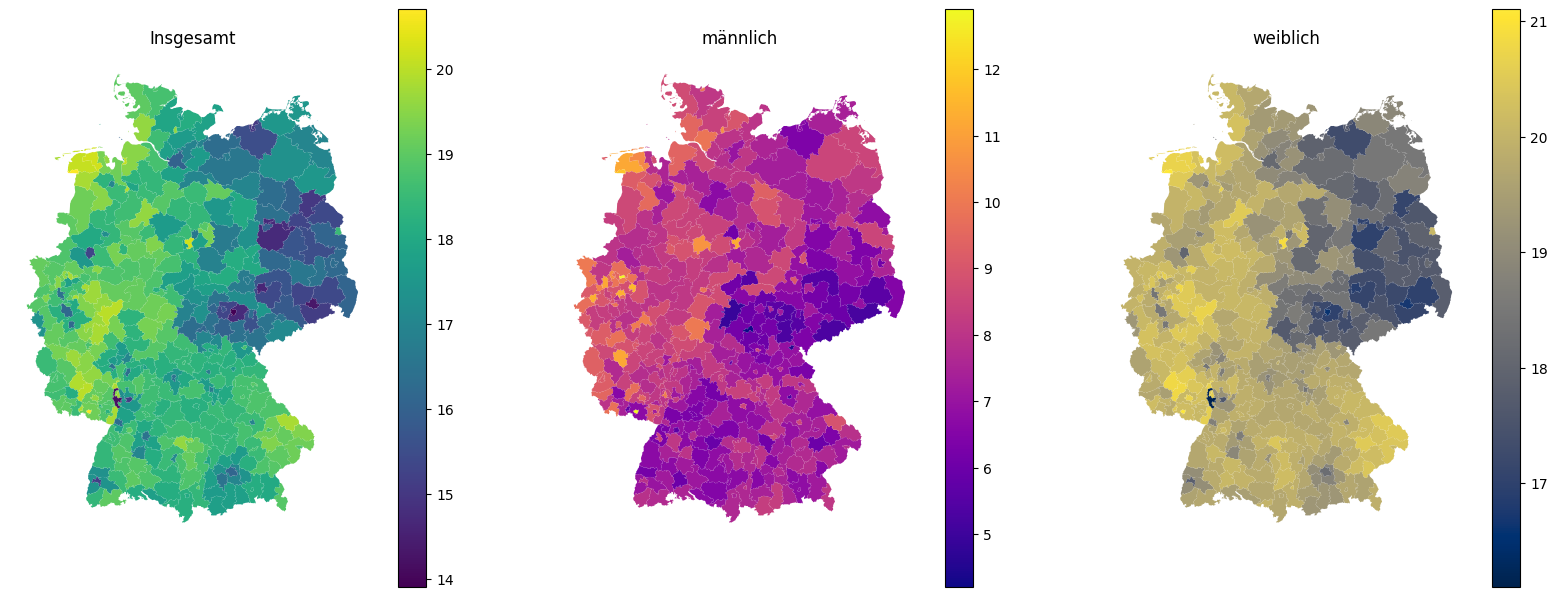

In [63]:
eg = pd.read_parquet(destatis_sources["eg_dauer"]["processed_file"])
gdf = gpd.read_parquet(processed_dir / "vg250_krs.parquet")

df = gpd.GeoDataFrame(
    pd.merge(
        eg, gdf[["ags", "geom"]],
        on="ags"
    ),
    geometry="geom"
)


fig, axs = plt.subplots(
    ncols=3,
    nrows=1,
    sharex=True, sharey=True,
)

fig.set_size_inches(20, 7.5)

z_var = "monate"
xfac_var = "fm"

# die Selektion von egplus und jahr ist dann als interaktiver Teil realisiert:
df_plot = df.query(
    'egplus == "Mit Elterngeld Plus"'
    'and jahr == 2023'
)

facet_var = "fm"
facets = df_plot[facet_var].unique()

cols = np.array([0, 1, 2])
subpltcoord = cols

# die drei Karten haben jeweils unterschiedliche Schwankungsbreiten und damit Farbskalen;
# daher benutzen wir auch drei unterschiedliche Paletten, damit nicht der Eindruck von
# Vergleichbarkeit entsteht:
colorpalettes = [
    "viridis",
    "plasma",
    "cividis",
]

for xy, facet in zip(subpltcoord, facets):

    df_facet = df_plot.loc[df_plot[facet_var].eq(facet)]

    x = xy
    df_facet.plot(
        ax=axs[x],
        column=z_var,
        legend=True,
        cmap=colorpalettes[x]
    )

    axs[x].set_title(facet)

for ax in axs:
    ax.axis("off")

## Teil 2: Steuerkraft als Karte

Wir sehen uns an, wie das Steueraufkommen pro Kopf bundesweit variiert.

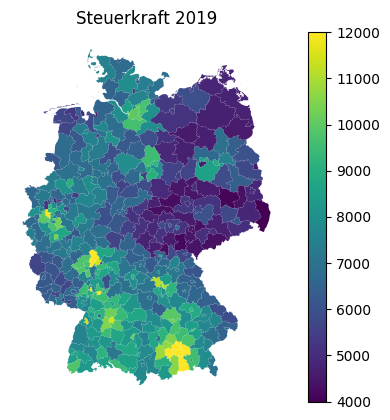

In [8]:
dfs = pd.read_parquet(destatis_sources["steuern"]["processed_file"])
# interaktiv:
dfs = dfs.query('jahr == 2019')

dfs = dfs.loc[dfs.rs.str.len().le(5)]
dfs["ags"] = dfs.rs.str.ljust(8, "0")

gdf = gpd.read_parquet(processed_dir / "vg250_krs.parquet")

df = gpd.GeoDataFrame(
    pd.merge(
        dfs, gdf[["ags", "geom"]],
        on="ags"
    ),
    geometry="geom"
).drop("rs", axis=1)

fig, ax = plt.subplots()

df.plot(
    ax=ax,
    column="steuer_pc",
    legend=True,
    cmap="viridis",
    vmax=12000,
)

ax.axis("off")
ax.set_title("Steuerkraft 2019")
plt.show()

# Teil 3: Steuerkraft und Bezugsdauer beim Elterngeld

Nun setzen wir beide Größen in Bezug.

In [9]:
df = pd.read_parquet(processed_dir / "kreise_steuern_egdauer.parquet")

# unnötige Einrückung in Kreisnamen entfernen:
df.krs = df.krs.str.lstrip()

# schönere Zahlendarstellung:
df["steuer_pc_pretty"] = df.steuer_pc.apply(num)

# Jahre sortieren:
df = df.sort_values(["jahr", "ags"]).reset_index(drop=True)

# die Ost-West-Markierung:
df["ostwest"] = df.ags.apply(lambda x: "Ost" if int(x[0:2]) > 10 else "West")

# auf ein Jahr festlegen:
df = df.loc[
    # df.jahr.eq(2019)
    df.fm.eq("Insgesamt")
    & df.egplus.eq("Mit Elterngeld Plus")
]

# Farben:
colormap = {
    "Ost": "#ff0000",
    "West": "#66ccff",
}

fig = go.Figure()

for jahr, grp in df.groupby("jahr"):

    for ostwest, lgrp in grp.groupby("ostwest"):

        fig.add_trace(
            go.Scatter(
                x=lgrp.steuer_pc,
                y=lgrp.monate,
                visible=jahr==2016,
                mode="markers",
                marker=dict(color=color_rgba(colormap[ostwest], .5), size=10, line=dict(width=1, color="black")),
                customdata=lgrp[["krs", "steuer_pc_pretty", "monate"]],
                hovertemplate="<b>%{customdata[0]}:</b><br><br>Steuerkraft: €%{customdata[1]}<br>durchschnittlich %{customdata[2]} Monate EG<extra></extra>",
                name=lgrp.ostwest.iloc[0] + " " + str(jahr)
            )
        )

steps = []
for i, jahr in enumerate(df.jahr.unique()):
    title = f"<b>Steuerkraft und Bezugsdauer beim Elterngeld</b><br>im Jahr {jahr}"

    # jeder Step definiert den Plot-Titel und welche Traces sichtbar sind
    step = dict(
        method="update",
        args=[
            {"visible": [False] * len(fig.data)},  # alle ausblenden...
            {"title": title}
        ]
    )
    # ...außer diesen:
    for idx in cuyo(fig, str(jahr)):
        step["args"][0]["visible"][idx] = True
    
    steps.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "Jahr "},
        pad={"t": 0},
        steps=steps,
        transition={"duration": 300, "easing": "cubic-in-out"},
    )
]

xticks = [5000, 10000, 15000, 20000]
yticks = list(range(23))

fig.update_layout(
    plot_bgcolor="rgba(0,0,0, .05)",
    width=800,
    height=600,
    margin=dict(t=50, r=10, b=20, l=50),
    xaxis=dict(
        tickvals=xticks,
        ticktext=[num(x) + " €" for x in xticks],
        range=[0, 20000],
    ),
    yaxis=dict(
        tickvals=yticks,
        ticktext=[str(x) + " Mon." for x in yticks],
        range=[14, 23],
    ),
    legend=dict(
        x=.7, y=.8,
        bgcolor="rgba(0,0,0,0)"
    ),
    sliders=sliders
)

fig.show()

# Wunschliste

- User können in der App entscheiden, welche Variable als Facette dargestellt wird
- Hover
- Zoom

In [10]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv"
dataset = pd.read_csv(url)

years = ["1952", "1962", "1967", "1972", "1977", "1982", "1987", "1992", "1997", "2002",
         "2007"]

# make list of continents
continents = []
for continent in dataset["continent"]:
    if continent not in continents:
        continents.append(continent)
# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [30, 85], "title": "Life Expectancy"}
fig_dict["layout"]["yaxis"] = {"title": "GDP per Capita", "type": "log"}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 500, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Year:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

# make data
year = 1952
for continent in continents:
    dataset_by_year = dataset[dataset["year"] == year]
    dataset_by_year_and_cont = dataset_by_year[
        dataset_by_year["continent"] == continent]

# make frames
for year in years:
    frame = {"data": [], "name": str(year)}
    for continent in continents:
        dataset_by_year = dataset[dataset["year"] == int(year)]
        dataset_by_year_and_cont = dataset_by_year[
            dataset_by_year["continent"] == continent]

        data_dict = {
            "x": list(dataset_by_year_and_cont["lifeExp"]),
            "y": list(dataset_by_year_and_cont["gdpPercap"]),
            "mode": "markers",
            "text": list(dataset_by_year_and_cont["country"]),
            "marker": {
                "sizemode": "area",
                "sizeref": 200000,
                "size": list(dataset_by_year_and_cont["pop"])
            },
            "name": continent
        }
        frame["data"].append(data_dict)

    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [year],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": year,
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)

fig_dict["data"] = fig_dict["frames"][0]["data"]


fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()

In [11]:
data_dict

{'x': [81.235, 80.204],
 'y': [34435.36744, 25185.00911],
 'mode': 'markers',
 'text': ['Australia', 'New Zealand'],
 'marker': {'sizemode': 'area',
  'sizeref': 200000,
  'size': [20434176.0, 4115771.0]},
 'name': 'Oceania'}